# 🐄 COWLAR TASK (Part 1)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA

## 🗄️ Data Preprocessing

In [2]:
# Read all the lines from the file
with open('./fea.csv', 'r') as f:
    lines = f.readlines()

# Convert the lines into a 2D array
data = []
for line in lines:
    data.append([int(x) for x in line.strip().split(',')])

data = np.array(data)
data.shape

(1700, 1024)

In [3]:
# Create an array for labels
labels = []
for i in range(10):
    for j in range(170):
        labels.append(i)

labels = np.array(labels)
labels.shape

(1700,)

In [4]:
def createDataSplit(data, numOfTrainingSamples, numOfTestingSamples, numOfClasses=10):

    # Calculate the total number of samples
    numOfSamples = numOfTestingSamples + numOfTrainingSamples

    # Create empty arrays to store training and testing data
    trainingData = np.empty([0, data.shape[1]], dtype=data.dtype)
    testingData = np.empty([0, data.shape[1]], dtype=data.dtype)
    trainingLabels = []
    testingLabels = []


    for i in range(numOfClasses):

        # Randomly select test samples without replacement
        testChoices = np.random.choice(np.arange(numOfSamples * i, numOfSamples * (i + 1)), size=numOfTestingSamples, replace=False)
        
        # Generate training samples by excluding test samples
        trainChoices = np.array([k for k in range(i * numOfSamples, (i + 1) * numOfSamples) if k not in testChoices])
        
        ## Add training and testing data to respective arrays
        trainingData = np.vstack([trainingData, data[trainChoices]])
        testingData = np.vstack([testingData, data[testChoices]])

        # Add class labels to respective lists
        trainingLabels = trainingLabels + [i for k in range(numOfTrainingSamples)]
        testingLabels = testingLabels + [i for k in range(numOfTestingSamples)]

    trainingLabels = np.array(trainingLabels)
    testingLabels = np.array(testingLabels)

    return trainingData, testingData, trainingLabels, testingLabels

In [5]:
# normalize the images
normData = np.float32(data) / 255.0

# create the data splits with 150/20 split
dataSplits = {}
for i in range(5):
    dataSplits[i] = createDataSplit(normData, 150, 20)

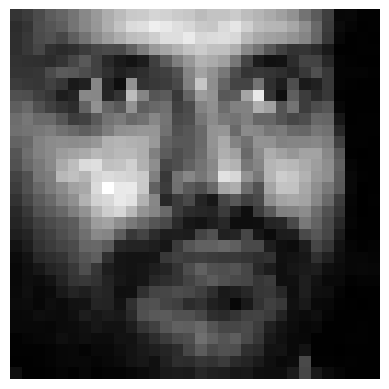

In [6]:
def viewImageFromFeatures(features):
    plt.imshow(features.reshape(32, 32).T, cmap='gray')
    plt.axis('off')

randImg = dataSplits[0][0][np.random.randint(0, 1500)]
viewImageFromFeatures(randImg)

## 🤖 k Nearest Neighbour

In [7]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def cosine_similarity(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)

    # Check if the points have the same dimensions
    if point1.shape != point2.shape:
        raise ValueError("Points must have the same dimensions")

    dot_prod = np.dot(point1, point2)
    norm_prod = np.linalg.norm(point1) * np.linalg.norm(point2)

    # Calculate the cosine similarity
    return dot_prod / norm_prod if norm_prod != 0 else 0

In [8]:
class kNN:
    def __init__(self, k, distanceMetric='euclidean'):
        self.k = k
        self.distMetric = distanceMetric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []

        # Iterate over each data point in X
        for i in range(X.shape[0]):
            distances = []
            # Calculate the distances between the current data point and all training data points
            for j in range(self.X_train.shape[0]):
                if self.distMetric == 'euclidean':
                    distances.append(euclidean_distance(X[i], self.X_train[j]))
                elif self.distMetric == 'cosine':
                    distances.append(cosine_similarity(X[i], self.X_train[j]))

            # Sort the distances and get the indices of the k nearest neighbors
            sorted_indices = np.argsort(distances)[:self.k]

            # Get the labels of the k nearest neighbors
            k_nearest_labels = self.y_train[sorted_indices]

            # Count the occurrences of each label
            unique, counts = np.unique(k_nearest_labels, return_counts=True)

            # Choose the label with the highest count as the predicted label
            y_pred.append(unique[np.argmax(counts)])

        return np.array(y_pred)

    def accuracy(self, y_pred, y_true):
        return np.sum(y_pred == y_true) / len(y_true)

### Using 150-20 Data Split

In [20]:
results = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime

        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results[i] = {}
    results[i]['accAvg'] = round(np.mean(accs), 4)
    results[i]['accStd'] = round(np.std(accs), 4)
    results[i]['timeAvg'] = round(np.mean(times), 4)
    results[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results)

,3,5,7,9,11,13,15
accAvg,0.9620,0.9450,0.9330,0.9210,0.8940,0.8770,0.8640
accStd,0.0103,0.0084,0.0103,0.0107,0.0174,0.0103,0.0097
timeAvg,3.3135,3.1324,2.9638,2.9586,2.9749,3.4111,3.0382
timeStd,0.5728,0.5421,0.3128,0.5076,0.4942,0.6082,0.3419


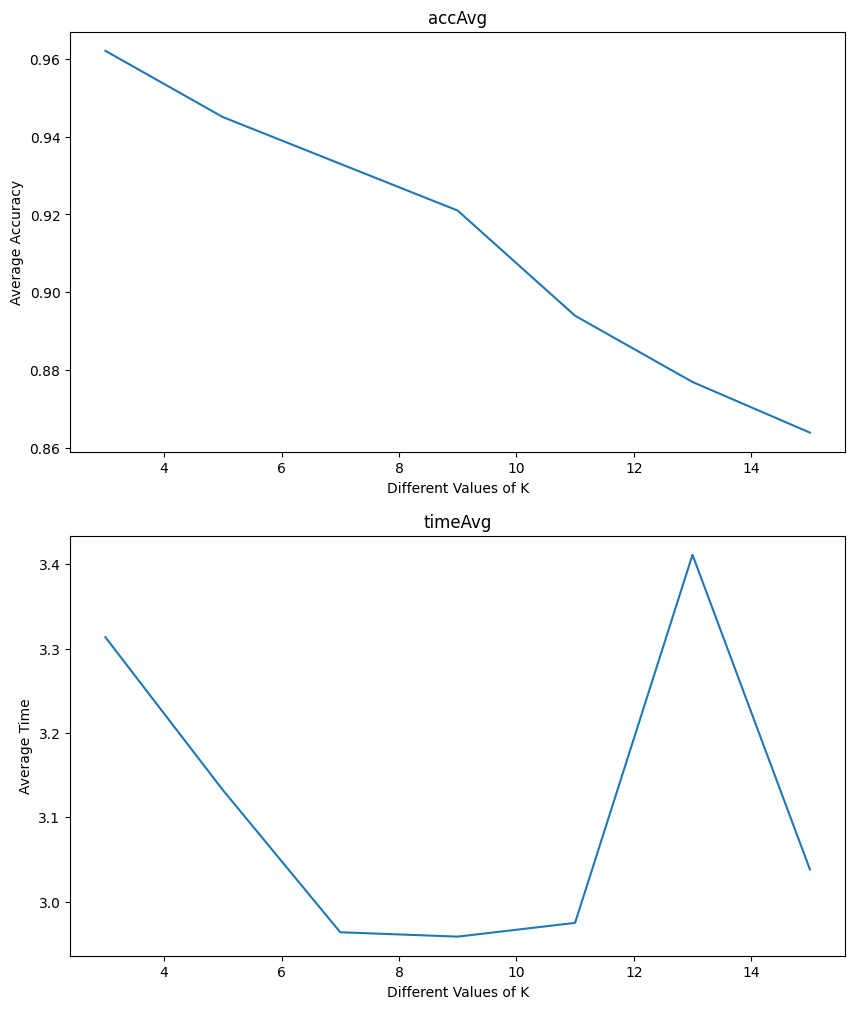

In [34]:
results = pd.DataFrame(results).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):

    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results.index, results[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

### Using 100-70 Data Split

In [36]:
# create the data splits with 100/70 split
dataSplits2 = {}
for i in range(5):
    dataSplits2[i] = createDataSplit(normData, 100, 70)

results2 = {}
for i in range(3, 16, 2):

    accs = []
    times = []

    for splitNum, split in dataSplits2.items():

        X_train, X_test, y_train, y_test = split
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for k=i
    results2[i] = {}
    results2[i]['accAvg'] = round(np.mean(accs), 4)
    results2[i]['accStd'] = round(np.std(accs), 4)
    results2[i]['timeAvg'] = round(np.mean(times), 4)
    results2[i]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results2)

,3,5,7,9,11,13,15
accAvg,0.9069,0.8780,0.8434,0.8303,0.8066,0.7851,0.7623
accStd,0.0115,0.0131,0.0178,0.0210,0.0211,0.0202,0.0136
timeAvg,6.9746,6.9195,7.0780,7.1156,6.8071,7.0587,7.0584
timeStd,0.4844,0.5077,0.6104,0.4652,0.5612,0.4413,0.5795


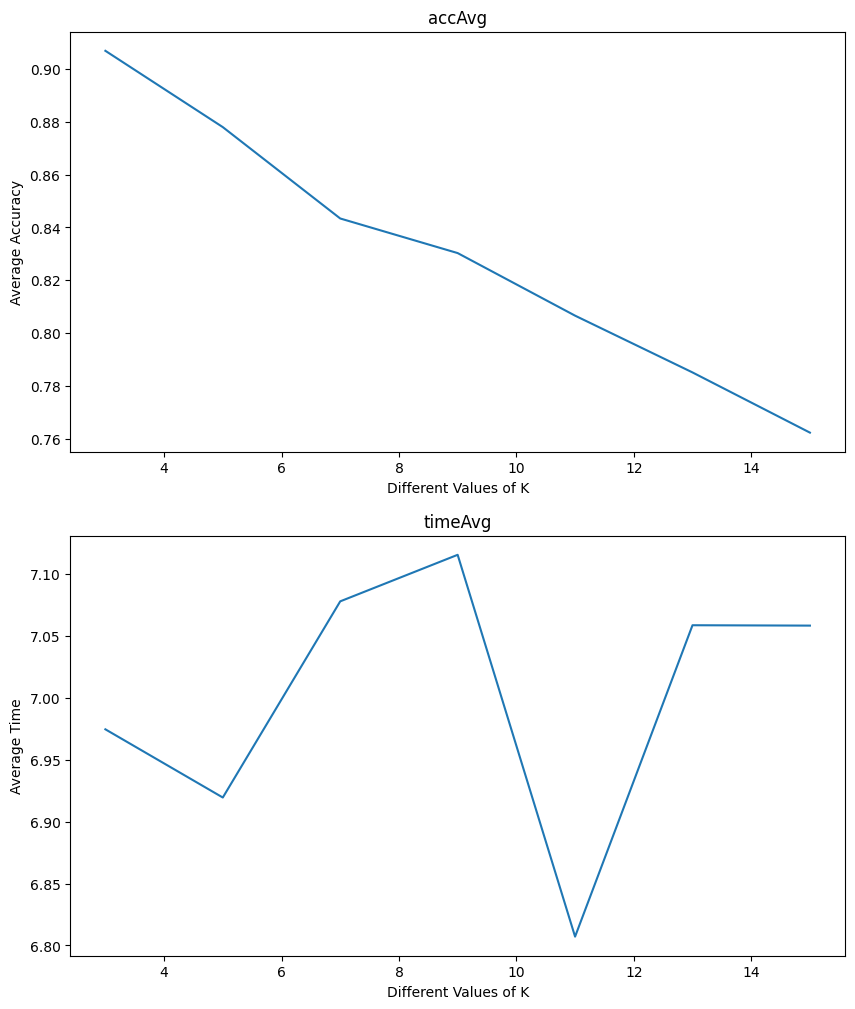

In [37]:
results2 = pd.DataFrame(results2).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results2.index, results2[col])
    plt.title(col)
    plt.xlabel('Different Values of K')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')

### Adding PCA to the Pipeline

In [51]:
results3 = {}
i = 3 # since in previous results k=3 gave best results

for n in range(1024, 0, -64):

    accs = []
    times = []
    
    for splitNum, split in dataSplits.items():

        X_train, X_test, y_train, y_test = split

        # Apply PCA on the training and testing data
        pca = PCA(n_components=n)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        classifier = kNN(i)

        # Fit the classifier to the training data
        classifier.fit(X_train, y_train)

        # Measure the start time of prediction
        startTime = time.time()
        y_pred = classifier.predict(X_test)

        # Calculate the computation time for predictions
        endTime = time.time()
        computationTime = endTime - startTime
        accs.append(classifier.accuracy(y_pred, y_test))
        times.append(computationTime)
    
    # Store the results for n_components=n
    results3[n] = {}
    results3[n]['accAvg'] = round(np.mean(accs), 4)
    results3[n]['accStd'] = round(np.std(accs), 4)
    results3[n]['timeAvg'] = round(np.mean(times), 4)
    results3[n]['timeStd'] = round(np.std(times), 4)

pd.DataFrame(results3)

,1024,960,896,832,768,704,640,576,512,448,384,320,256,192,128,64
accAvg,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9620,0.9630,0.9640,0.9620,0.9630,0.9630
accStd,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0103,0.0093,0.0086,0.0068,0.0081,0.0103
timeAvg,3.3044,3.3707,3.3629,3.1547,2.8296,2.8669,2.7292,2.9436,2.7719,2.6902,2.6697,2.7715,2.4982,2.2596,2.2157,2.2540
timeStd,0.2603,0.3549,0.3650,0.2846,0.2093,0.3023,0.1798,0.3895,0.3318,0.2204,0.2699,0.3142,0.2157,0.2944,0.1501,0.3246


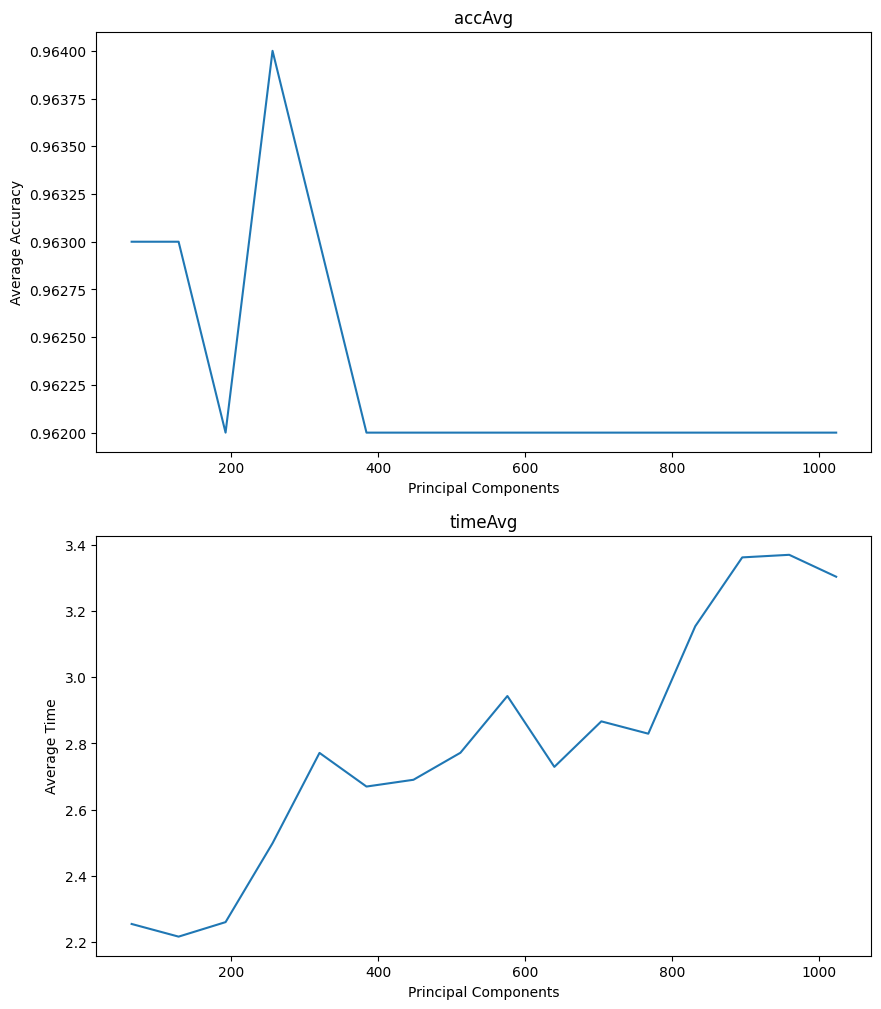

In [53]:
results3 = pd.DataFrame(results3).T
plt.figure(figsize=(10, 12))

# Iterate over the columns 'accAvg' and 'timeAvg'
for i, col in enumerate(['accAvg', 'timeAvg']):
    
    # Create a subplot for each column
    plt.subplot(2, 1, i + 1)
    plt.plot(results3.index, results3[col])
    plt.title(col)
    plt.xlabel('Principal Components')
    plt.ylabel('Average Accuracy' if col == 'accAvg' else 'Average Time')